# FT-Transformer Model

In [32]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Data Preprocessing

In [5]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [6]:
features_df

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
...,...,...,...,...,...,...,...,...,...,...,...
99995,1.000000,0,1,0,0,0,0,1,0,0.475269,0.683419
99996,0.666667,0,0,0,0,0,0,1,0,0.562420,0.861997
99997,0.666667,0,1,0,0,0,0,1,0,0.225903,0.243447
99998,0.333333,0,1,1,0,0,0,0,0,0.073531,0.058008


In [7]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 1   is_EMEA                                 100000 non-null  int64  
 2   is_Webshop                              100000 non-null  int64  
 3   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 4   is_industry_Manufacturing               100000 non-null  int64  
 5   is_industry_Other                       100000 non-null  int64  
 6   is_industry_RetailTrade                 100000 non-null  int64  
 7   is_industry_Services                    100000 non-null  int64  
 8   is_industry_WholesaleTrade              100000 non-null  int64  
 9   license_value_score                     100000 non-null  float64
 10  customer_value_score                    10000

## Feature-Tokenizer Transformer (FT-Transformer) Model

In [16]:
class FTTransformer:
    def __init__(self, input_dim, embedding_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.1):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.dropout_rate = dropout_rate

        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        
        # Embedding layer
        x = Dense(self.embedding_dim, activation='relu')(inputs)
        x = Dropout(self.dropout_rate)(x)

        # Expand dims of input embeddings to (batch_size, sequence_length, embedding_dim)
        x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
        
        # Add [CLS] token
        cls_token = tf.keras.layers.Lambda(lambda x: tf.ones_like(x[:, :1, :]) * 0.0)(x)
        x = tf.keras.layers.Concatenate(axis=1)([cls_token, x])
        x = LayerNormalization()(x)

        # Transformer encoder
        for _ in range(self.num_transformer_blocks):
            attn_output = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)(x, x)
            attn_output = Dropout(self.dropout_rate)(attn_output)
            attn_output = LayerNormalization()(attn_output + x)
            
            ff_output = Dense(self.ff_dim, activation='relu')(attn_output)
            ff_output = Dense(self.embedding_dim)(ff_output)
            ff_output = Dropout(self.dropout_rate)(ff_output)
            x = LayerNormalization()(ff_output + attn_output)
        
        # Global average pooling
        x = GlobalAveragePooling1D()(x)

        # Output layer (for embeddings)
        outputs = Dense(self.embedding_dim, activation='linear')(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
        return model

    def train(self, data, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        self.model.fit(data, data, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

    def get_embeddings(self, X):
        return self.model.predict(X)

    def summary(self):
        self.model.summary()

In [27]:
# Parameters
input_dim = features.shape[1]
embedding_dim = features.shape[1]
num_heads = 4
ff_dim = 128
num_transformer_blocks = 2
dropout_rate = 0.2
epochs = 5
batch_size = 64

In [28]:
# Instantiate the model
model = FTTransformer(
    input_dim=input_dim,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout_rate=dropout_rate
)

In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 11)           132         ['input_6[0][0]']                
                                                                                                  
 dropout_17 (Dropout)           (None, 11)           0           ['dense_20[0][0]']               
                                                                                                  
 lambda_8 (Lambda)              (None, 1, 11)        0           ['dropout_17[0][0]']             
                                                                                            

In [30]:
model.train(features, epochs=10, batch_size=64)

Epoch 1/5
1563/1563 [==============================] - 17s 8ms/step - loss: 0.0751
Epoch 2/5
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0380
Epoch 3/5
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0306
Epoch 4/5
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0267
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0245


In [31]:
# Get embeddings
embeddings = model.get_embeddings(features)

3125/3125 [==============================] - 7s 2ms/step


## PCA

In [33]:
pca = PCA()
pca.fit(embeddings)

PCA()

In [34]:
print(pca.explained_variance_ratio_)

[2.43658661e-01 2.13898776e-01 1.42082269e-01 1.10590382e-01
 8.91238038e-02 7.41389603e-02 6.04885913e-02 4.62776433e-02
 1.97407245e-02 1.87537635e-07 9.80335769e-10]


Number of components explaining at least 80% variance: 6


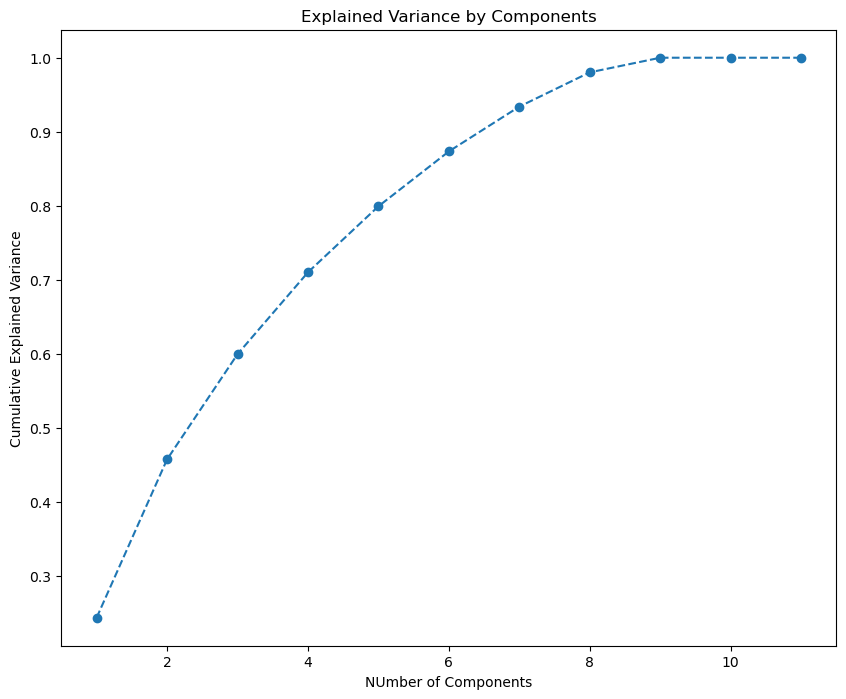

In [35]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,12), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

In [39]:
pca = PCA(n_components=6)
features_pca = pca.fit_transform(embeddings)

## Determine the number of clusters(k)

In [40]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


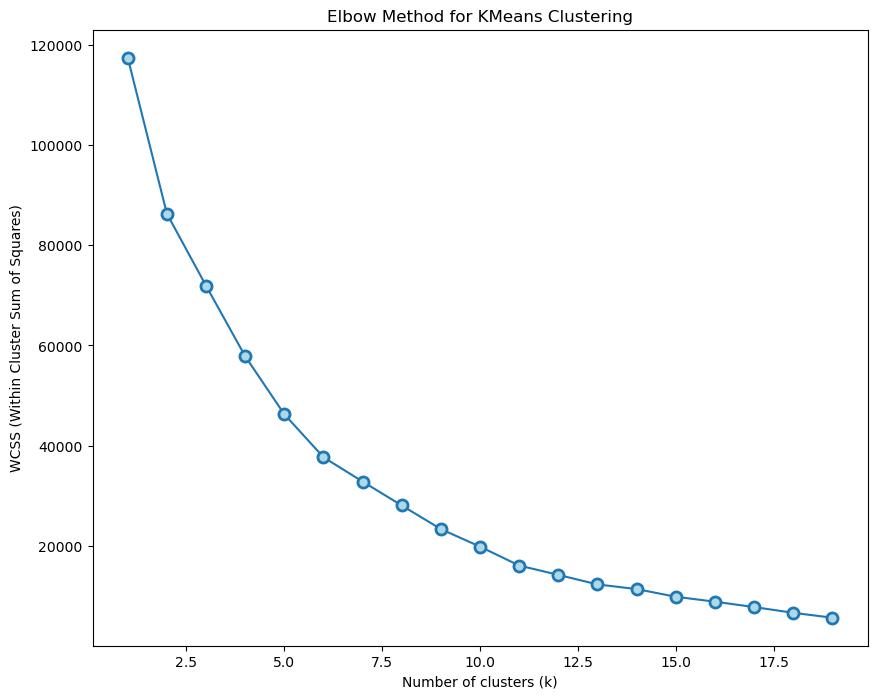

In [41]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [42]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=6, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-6: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_latex = df_pca.groupby(['cluster_kmeans']).mean()
df_latex

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,clusters
cluster_kmeans,,,,,,,,,,,,,,,,,,
0,0.544663,0.745834,0.492900,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.437531,0.376845,-0.556033,0.293607,-0.129530,0.690194,-0.331820,-0.025281,0.0
1,0.694186,0.729839,0.453339,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.473773,0.419816,-0.450972,0.180833,0.115985,-0.705760,-0.494293,0.022395,1.0
2,0.376806,0.705188,1.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.332411,0.343063,0.816823,0.219325,0.064287,0.022787,-0.025701,-0.066402,2.0
3,0.609232,0.809114,0.325311,0.292132,0.0,0.0,0.000000,0.0,0.707868,0.507979,0.442077,-0.527142,-0.038357,-0.017723,-0.120566,0.513042,-0.443388,3.0
4,0.436769,0.774892,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.563272,0.477326,0.316125,-0.760852,0.057532,0.060624,-0.034519,0.035799,4.0
5,0.441658,0.796570,0.651458,0.261671,0.0,0.0,0.738329,0.0,0.000000,0.390220,0.361482,-0.207662,0.396573,-0.150405,-0.090286,0.448181,0.528610,5.0


In [43]:
df_latex.drop(columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'clusters'], inplace=True)
df_latex = df_latex.T

In [44]:
df_latex

cluster_kmeans,0,1,2,3,4,5
yeojohnson_revenue_in_eur_bin,0.544663,0.694186,0.376806,0.609232,0.436769,0.441658
is_EMEA,0.745834,0.729839,0.705188,0.809114,0.774892,0.796570
is_Webshop,0.492900,0.453339,1.000000,0.325311,0.000000,0.651458
is_industry_FinanceInsuranceRealEstate,0.000000,0.000000,0.000000,0.292132,0.000000,0.261671
is_industry_Manufacturing,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
is_industry_Other,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
is_industry_RetailTrade,0.000000,0.000000,0.000000,0.000000,0.000000,0.738329
is_industry_Services,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
is_industry_WholesaleTrade,0.000000,0.000000,0.000000,0.707868,0.000000,0.000000
license_value_score,0.437531,0.473773,0.332411,0.507979,0.563272,0.390220


In [45]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
    0 &     1 &     2 &     3 &     4 &     5 \\
\midrule
0.545 & 0.694 & 0.377 & 0.609 & 0.437 & 0.442 \\
0.746 & 0.730 & 0.705 & 0.809 & 0.775 & 0.797 \\
0.493 & 0.453 & 1.000 & 0.325 & 0.000 & 0.651 \\
0.000 & 0.000 & 0.000 & 0.292 & 0.000 & 0.262 \\
0.000 & 1.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
1.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.738 \\
0.000 & 0.000 & 1.000 & 0.000 & 1.000 & 0.000 \\
0.000 & 0.000 & 0.000 & 0.708 & 0.000 & 0.000 \\
0.438 & 0.474 & 0.332 & 0.508 & 0.563 & 0.390 \\
0.377 & 0.420 & 0.343 & 0.442 & 0.477 & 0.361 \\
\bottomrule
\end{tabular}
\end{table}



In [47]:
df_pca.cluster_kmeans.value_counts()

2    22014
4    21714
0    15423
3    14045
1    13566
5    13238
Name: cluster_kmeans, dtype: int64

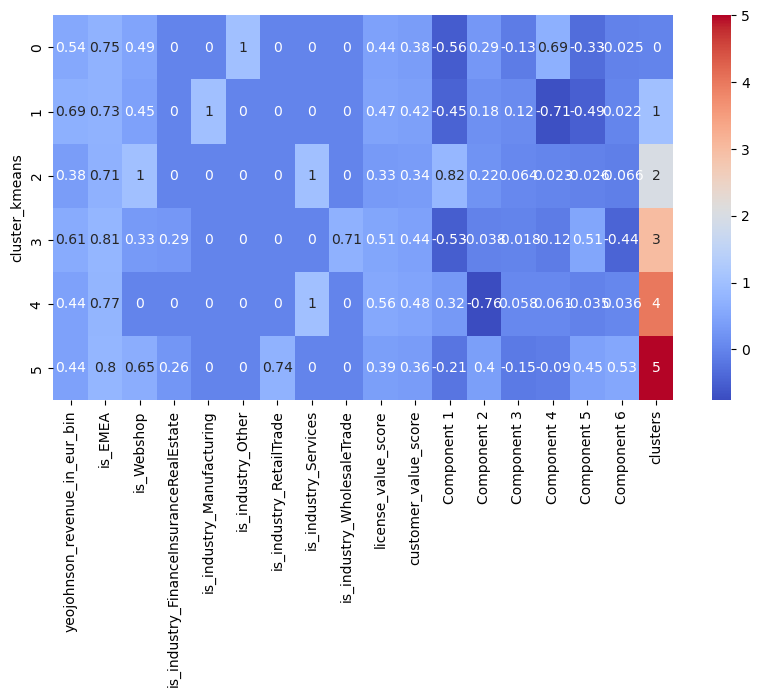

In [48]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [49]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1200, 
                    title="FT-Transformer Model 10-Feature Set Radar Chart")
fig.show()

In [50]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,15423
1,1,13566
2,2,22014
3,3,14045
4,4,21714
5,5,13238


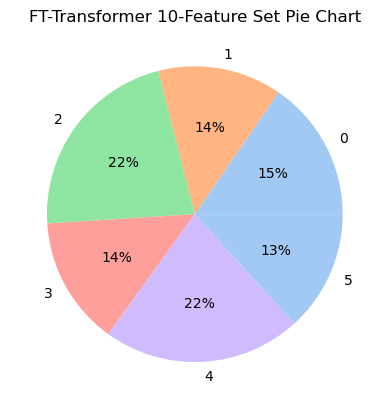

In [51]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('FT-Transformer 10-Feature Set Pie Chart')
plt.show()

## Evaluation

In [53]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.398


In [41]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(embeddings, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 267.660
